In [286]:
%matplotlib inline
import re
import numpy as np
import pandas as pd

from IPython.display import display, HTML
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime

In [310]:
def get_result_metrics(filepath):
    # get lines with results
    lines = []
    marker = 'Got result: '
    with open(filepath) as f:
        for line in f.readlines():
            if marker in line:
                lines.append(line.split(marker, 1)[1])
    
    def extract(string, key, dtype):
        if dtype is bool:
            return True if re.search(' {}=((True)|(False)) '.format(key), run).group(1) == 'True' else False
        if dtype is float:
            return float(re.search(' {}=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?) '.format(key), run).group(1))
        if dtype is int:
            return float(re.search(' {}=(\d+) '.format(key), run).group(1))
    
    # extract metrics
    runs = []
    for run in lines:
        data = {
            #'success': extract(run, 'success', bool),
            'time_created': extract(run, 'time_created', float),
            'time_input_received': extract(run, 'time_input_received', float),
            'time_compute_started': extract(run, 'time_compute_started', float),
            'time_result_sent': extract(run, 'time_result_sent', float),
            'time_result_received': extract(run, 'time_result_received', float),
            'time_running': extract(run, 'time_running', float),
            'time_serialize_inputs': extract(run, 'time_serialize_inputs', float),
            'time_deserialize_inputs': extract(run, 'time_deserialize_inputs', float),
            'time_serialize_results': extract(run, 'time_serialize_results', float),
            'time_deserialize_results': extract(run, 'time_deserialize_results', float),
            'time_result_received': extract(run, 'time_result_received', float),
        }
        
        try:
            data['time_dereference_inputs'] = extract(run, 'time_dereference_inputs', float)
        except:
            data['time_dereference_inputs'] = 0
        
        data['client_to_method_server'] = data['time_input_received'] - (
                data['time_created'] + data['time_serialize_inputs'])
        data['worker_to_method_server'] = data['time_result_sent'] - (
                data['time_compute_started'] + data['time_running'] + 
                data['time_deserialize_inputs'] + data['time_serialize_results'] + 
                data['time_dereference_inputs'])
        data['method_server_to_client'] = data['time_result_received'] - (
                data['time_result_sent'] + data['time_deserialize_results'])
        data['time_serialization'] = sum(data[key] for key in data if 'serialize' in key)
        data['time_created_to_result_received'] = data['time_result_received'] - data['time_created']
        
        runs.append(data)
        
    return pd.DataFrame(runs)

def aggregate_runs(run_paths):
    data = []
    for path in run_paths:
        results = pd.Series({'path': path})

        with open(path) as f:
            first_line = f.readline()
            timestamp = first_line.split(' - ')[0]
            value_server = True if re.search('use_value_server=(.+),', first_line).group(1) == 'True' else False
            results['value_server'] = value_server
            results['task_count'] = int(re.search('task_count=(\d+),', first_line).group(1))
            results['task_input_size'] = int(re.search('task_input_size=(\d+),', first_line).group(1))
            results['task_interval'] = float(re.search('task_interval=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?),', first_line).group(1))
            results['task_output_size'] = int(re.search('task_output_size=(\d+),', first_line).group(1))
            results['time_start'] = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S,%f").timestamp()

        function_results = get_result_metrics(path)
        results['n_tasks'] = len(function_results.index)
        results = pd.concat([results, function_results.median()])
                
        data.append(results)
        
    return pd.concat(data, axis=1).T

In [300]:
cols = ['client_to_method_server', 'worker_to_method_server', 'method_server_to_client', 'time_serialization']
ind = np.arange(len(cols))
width = 0.35

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,n_tasks,time_created,time_input_received,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_dereference_inputs,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/value_vs_no_value_100x100MB/2021-02-10_22...,True,100,100,0.1,0,1.61299e+09,100,1.61299e+09,1.61299e+09,...,2.5037e-05,0.000142525,0.000313211,4.4896e-05,0,0.000380874,0.00604534,0.000410676,0.000529523,12.7866
1,runs/value_vs_no_value_100x100MB/2021-02-10_21...,False,100,100,0.1,0,1.61299e+09,100,1.61299e+09,1.61299e+09,...,0.000220502,0.00141141,0.00147056,0.000219422,0,0.00149047,0.00497699,0.00208712,0.00335164,15.497


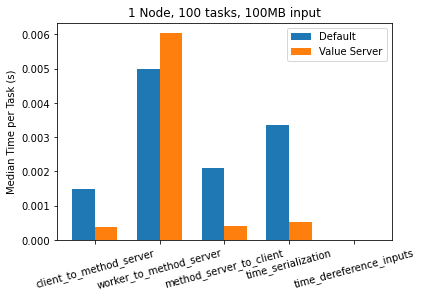

In [312]:
rundir = 'runs/value_vs_no_value_100x100MB'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 100 tasks, 100MB input')
plt.ylabel('Median Time per Task (s)')
plt.xticks(ind + width / 2, cols, rotation=15)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,n_tasks,time_created,time_input_received,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_dereference_inputs,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/value_vs_no_value_1000x10MB/2021-02-10_22...,False,1000,10,0.1,0,1.613e+09,1000,1.613e+09,1.613e+09,...,5.723e-05,0.000311082,0.000439473,7.43895e-05,0,0.000499964,0.00355375,0.000656366,0.000890601,0.0206745
1,runs/value_vs_no_value_1000x10MB/2021-02-10_22...,True,1000,10,0.1,0,1.613e+09,1000,1.613e+09,1.613e+09,...,2.81235e-05,0.000147971,0.000303977,4.6991e-05,0,0.000389934,0.00472414,0.000454545,0.00053231,0.022705


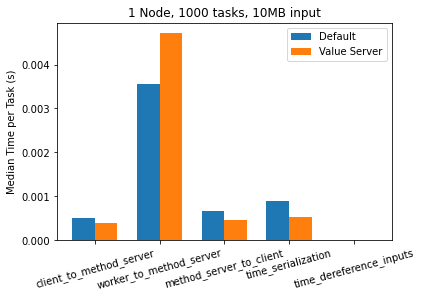

In [313]:
rundir = 'runs/value_vs_no_value_1000x10MB'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 1000 tasks, 10MB input')
plt.ylabel('Median Time per Task (s)')
plt.xticks(ind + width / 2, cols, rotation=15)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,n_tasks,time_created,time_input_received,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_dereference_inputs,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/value_vs_no_value_1000x50MB/2021-02-10_22...,False,1000,50,0.1,0,1.613e+09,1000,1.613e+09,1.613e+09,...,0.00012954,0.000798176,0.000895546,0.000140616,0,0.000972629,0.00434375,0.00139022,0.00197603,0.0243305
1,runs/value_vs_no_value_1000x50MB/2021-02-10_22...,True,1000,50,0.1,0,1.613e+09,1000,1.613e+09,1.613e+09,...,2.58855e-05,0.000145386,0.000306072,4.6008e-05,0,0.000376701,0.00536001,0.0004282,0.00052781,0.02388


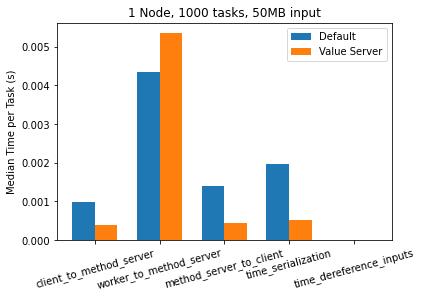

In [314]:
rundir = 'runs/value_vs_no_value_1000x50MB'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 1000 tasks, 50MB input')
plt.ylabel('Median Time per Task (s)')
plt.xticks(ind + width / 2, cols, rotation=15)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,n_tasks,time_created,time_input_received,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_dereference_inputs,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/value_vs_no_value_100x100MB_v2/2021-02-10...,False,100,100,0.1,0,1.613e+09,100,1.613e+09,1.613e+09,...,0.000238789,0.00140646,0.00144179,0.000241258,9.42945e-05,0.00182676,0.00524879,0.00239789,0.00333229,11.9731
1,runs/value_vs_no_value_100x100MB_v2/2021-02-10...,True,100,100,0.1,0,1.613e+09,100,1.613e+09,1.613e+09,...,2.8169e-05,0.000152611,0.000323497,4.59815e-05,0.00275469,0.000433207,0.00385404,0.000469208,0.000553532,34.0269


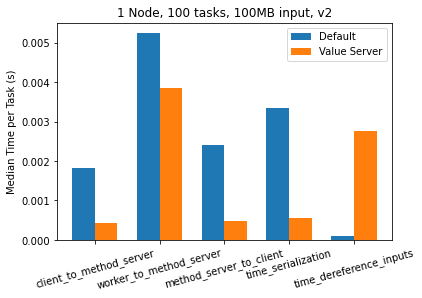

In [315]:
cols = ['client_to_method_server', 'worker_to_method_server', 'method_server_to_client', 'time_serialization', 'time_dereference_inputs']
ind = np.arange(len(cols))
width = 0.35
rundir = 'runs/value_vs_no_value_100x100MB_v2'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 100 tasks, 100MB input, v2')
plt.ylabel('Median Time per Task (s)')
plt.xticks(ind + width / 2, cols, rotation=15)
plt.legend(loc='best')
plt.show()